In [2]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from gurobi import *

np.set_printoptions(precision=3)
pd.options.display.max_columns = None
from IPython.display import display, HTML
from IPython.display import display_html

sns.set(font_scale=1.5)


### Define some utility functions for better understanding how the solvers / and online allocation is working

In [3]:
def display_3D(tableaus_int, tableaus_float, names, c, k, T, alphas):
    '''Given an array of numpy arrays, transforms to dataframes and displays'''
    
    metadf = pd.DataFrame({
        'copies' :[c[i] for i in range(allocs.shape[0])],
        'use times' :[k[i] for i in range(allocs.shape[0])]
    })
    
    html_str = ('<th>' 
                + ''.join([f'<td style="text-align:center">{name}</td>' for name in names])
                + '</th>')

    int_ixs = len(tableaus_int)-1
    tableaus_int.extend(tableaus_float)
    
    for i in range(T):
        row_dfs = [pd.DataFrame(tableau[:,:,i]) for tableau in tableaus_int]
    
        html_str += ('<tr>' + "<td style='vertical-align:center'> t = {}".format(i) +
                     f"<td style='vertical-align:top'>{metadf.to_html(index=False, float_format='%i')}</td>" +
                     ''.join(f"<td style='vertical-align:top'> {df.to_html(index=False, float_format=ix_to_format(ix,int_ixs))}</td>"
                             for ix,df in enumerate(row_dfs)) + 
                     '</tr>')
        
    
    html_str = f'<table>{html_str}</table>'
    
    
    columns=["t="+str(t) for t in range(T)]
    index=["i="+str(i) for i in range(I)]
    dfa = pd.DataFrame(alphas.reshape(I,T),columns=columns, index=index)

    columns = ["j="+str(j) for j in range(J)]
    dfb = pd.DataFrame(betas.reshape(1,J),columns=columns)

    html_str += f'<table><th><td style="text-align:center">alpha[i,t]</td><td style="text-align:center">beta[j]</td></th><tr><td></td><td>{dfa.to_html()}</td><td>{dfb.to_html()}</td></tr></table>' 
    
    display_html(html_str, raw=True) 

    
def ix_to_format(ix,intix):
    if ix > intix:
        return '%.3e'
    elif ix > intix:
        return '%.3f'
    else:
        return '%i'
        
def check_comp_terms(I,J,T,alphas, betas):
    
    comp_terms = np.zeros((I,J,T))
    for t in range(T):
        for j in range(J):
            for i in range(I):
                    comp_terms[i,j,t] = pairing_weights[i,j,t] - sum_alpha_it(alphas,i,t) - betas[j]                  
    return comp_terms

def check_comp_slackness(I,J,T,alphas,valid_matches, allocs):
    
    comp_slackness = np.zeros(valid_matches.shape)
    
    for t in range(T):
        for j in range(J):
            for i in range(I):
                    comp_slackness[i,j,t] = (pairing_weights[i,j,t] - sum_alpha_it(alphas,i,t) - betas[j]) * allocs[i,j,t]
                    
    return comp_slackness

### General utility functions

In [4]:
def print_tableau(matches):
    for i in range(matches.shape[2]):
        print("t=",i)
        print(matches[:,:,i])

def create_tableau(I,J,T):
    valid_matches = np.zeros((I,J,T), np.int)

    #valid allocations based on arival time
    for t in range(T):
        valid_matches[:,max(0,t-d):min(t+1,J),t] = 1

    #make weights uniform across time
    pairing_weights = np.random.random(valid_matches.shape) 
#     for t in range(1,pairing_weights.shape[2]):
#         pairing_weights[:,:,t] = pairing_weights[:,:,0]
    
    pairing_weights[0,:,:] =  0
    pairing_weights[valid_matches == 0] = -1
    pairing_weights[1:,:,:] = np.round(pairing_weights[1:,:,:],decimals=5)

    return valid_matches, pairing_weights

# Primal-Dual Solver Implementation

### Solver utility functions

In [5]:
def in_constraint(v):
    if v[1]:
        return True
    else:
        return False

def make_alpha_mapping(I,J,T,alphas,valid_matches):
    '''Creates an index into the alpha array for each position in valid matches'''
    constraints_d, _ = dual_constraint_matrix(valid_matches,pairing_weights,I,J,T)
    constraints_d = constraints_d[:,:alphas.size]
    alpha_map = np.zeros((*valid_matches.shape,constraints_d.shape[1]),dtype=np.bool)

    cix=0
    for i in range(I):
            for j in range(J):
                for t in range(T):
                    if valid_matches[i][j][t]:
                        alpha_map[i,j,t,:] = constraints_d[cix,:]
                        cix += 1
    return alpha_map

def sum_alpha_it(alphas,i,t):
    '''Return the alpha terms summed at a given i,t'''
    alpha_it = alphas.reshape(I,T)
    startit = max(t-k[i]+1,0)
    return np.sum(alpha_it[i,startit:t+1])
    

### Convert the problem formulation to matricies of the form `Ax = b`

To make the dual constraint matrix: 
- Create a constraint map to see which alphas/betas apply at a given location in the primal. Each valid location will correspond to a constraint in the dual, and the variables == 1 will be those in the `cmap[i][j][t]`

In [6]:
def primal_constraint_matrix(valid_matches, I,J,T):

    constraints = np.zeros((T*I+J,valid_matches.size),dtype=np.float128)
    cix = 0
    
    #constraints limiting to one resource allocation in the time interval
    for i in range(I):
        for t in range(T):
            constraint = np.zeros((I,J,T), np.int)
            valid_mask = constraint.copy()
            endix = min(t+k[i],T)
            valid_mask[i,:,t:endix] = 1 
            constraint[(valid_mask == 1)] = 1
            constraints[cix,:] = constraint.reshape((1, constraint.shape[0] * constraint.shape[1] * constraint.shape[2]))
            cix += 1

    #constraints limiting each agent to only match once            
    for j in range(J):
        constraint = np.zeros((I,J,T), np.int)
        valid_mask = constraint.copy()
        valid_mask[1:,j,:] = 1

        constraint[(valid_matches == 1) & (valid_mask ==1)] = 1
        constraints[cix+j,:] = constraint.reshape((1, constraint.shape[0] * constraint.shape[1] * constraint.shape[2]))
    
    return constraints


def dual_constraint_matrix(valid_matches,pairing_weights,I,J,T):
    '''
    Dual constraint matrix: Number IJT positions * number dual variables
             - Each row corresponds to an IJT position in the grid
             - Each column corresponds to a dual variable 
    '''
    num_positions = I*J*T
    num_primal_constraints = I*T+J
    dual_constraint_matrix = np.zeros((num_positions, num_primal_constraints))
    
    inequalities = np.zeros(num_positions)
    constraint_map = np.zeros((I,J,T,num_primal_constraints), np.int) 
    
    cix = 0

    #constraints limiting to one resource allocation in the time interval
    for i in range(I):
        for t in range(T):
            constraint = np.zeros((I,J,T), np.int)
            valid_mask = constraint.copy()

            endix = min(t+k[i],T)
            valid_mask[i,:,t:endix] = 1 
            constraint[(valid_mask == 1)] = 1
            constraint_map[:,:,:,cix] = constraint.copy()
            cix += 1

    #constraints limiting each agent to only match once            
    for j in range(J):
        constraint = np.zeros((I,J,T), np.int)
        valid_mask = constraint.copy()
        valid_mask[1:,j,:] = 1
        constraint[valid_mask ==1] = 1
        constraint_map[:,:,:,cix] = constraint.copy()
        cix += 1
    
    cix = 0
    for i in range(I):
        for j in range(J):
            for t in range(T):
                dual_constraint_matrix[cix,:] = constraint_map[i,j,t,:] 
                inequalities[cix] = pairing_weights[i,j,t]
                cix += 1
    
    return dual_constraint_matrix, inequalities


### Solving the primal and dual via the Gurobi library

In [7]:
def primal_solutions(valid_matches, pairing_weights, I, J, T):
   
    m = Model("dynamicmatch_primal")
    m.modelSense = GRB.MAXIMIZE
    m.setParam( 'OutputFlag', False )
    m.setParam( 'NumericFocus', 3)
    
    weights = pairing_weights.reshape(pairing_weights.shape[0] * pairing_weights.shape[1] * pairing_weights.shape[2])
    constraints = primal_constraint_matrix(valid_matches, I,J,T)
    
    keys = range(constraints.shape[1])
    variables = m.addVars(keys,
                    vtype=GRB.CONTINUOUS,
                     obj=weights,
                     name="primal",
                     lb=0)

    for cix, constraint in enumerate(constraints):
        equality = c[cix // T] if cix < T * I else 1
        m.addConstr(sum(variables[o]*c for o,c in filter(in_constraint, zip(variables,constraint))) <= equality)

    m.optimize()
    allocations = np.array([variables[var].X for var in variables], dtype=np.float128).reshape(pairing_weights.shape)

    return m.objVal, allocations


def dual_solutions(valid_matches, pairing_weights, I, J, T):
    md = Model("dynamicmatch_dual")
    md.modelSense = GRB.MINIMIZE
    md.setParam( 'OutputFlag', False )
    md.setParam( 'NumericFocus', 3)

    constraints_d, inequalities = dual_constraint_matrix(valid_matches,pairing_weights,I,J,T)
    variables_d = np.ones(constraints_d.shape[1])
    
    for ix in range(constraints_d.shape[1]):
        variables_d[ix] = c[ix // T] if ix < T * I else 1
    
    keys = range(constraints_d.shape[1])
    variables = md.addVars(keys,
                    vtype=GRB.CONTINUOUS,
                    obj=variables_d,
                    name="dual",
                    lb=0)

    for cix, constraint in enumerate(constraints_d):
        constr = inequalities[cix] + sum( variables[o]*-1*c for o,c in filter(in_constraint, zip(variables,constraint))) <= 0
        md.addConstr(constr)
        
    md.optimize()
    duals = np.array([variables[var].X for var in variables],dtype=np.longdouble)
    betas = duals[duals.size - J:]
    alphas = duals[:duals.size - J]
    
    return md.objVal, alphas, betas


# Online-Dual Implementation 

In [8]:
def online_matching(I,J,T,k,c,alphas,betas,allocs,valid_matches,pairing_weights):
    '''later remove beta from comparison and simplify candidate match structure'''

    online_allocations = np.zeros(pairing_weights.shape)
    utility = 0
    candidate_matches = valid_matches.copy()
    
    resource_uses = np.zeros((pairing_weights.shape[0],pairing_weights.shape[2]))

    for t in range(T):
        for j in range(J):
    
            if candidate_matches[0,j,t]:

                alpha_sums = np.array([sum_alpha_it(alphas,i,t) for i in range(I)])
                betai = betas[j] * np.ones(alpha_sums.shape)       
                comps = pairing_weights[:,j,t] - alpha_sums - betai

                alloc_ix = get_allocation_from_comparison(comps, pairing_weights[:,j,t], c, resource_uses[:,t] )
                
                #if resource already in use wait for it to become free
                if alloc_ix != -1:
                    
                    online_allocations[alloc_ix, j, t] = 1
                    utility += pairing_weights[alloc_ix,j,t]
                    
                    #Agent only leaves the market if it doesn't self match
                    if alloc_ix != 0:
                        candidate_matches[:,j,:] = 0
                    
                    resource_uses[alloc_ix,t:t+k[alloc_ix]] += 1

    return utility, online_allocations


def get_allocation_from_comparison(comps, weights, c,resource_uses ):
    '''Returns max comparison index, max weight if tie'''
    w = weights.copy()
    
    maxval = np.max(comps)
    
    #tie case
    if sum(comps == maxval) > 1:
        tie_ixs = np.zeros(comps.shape, np.bool)
        tie_ixs[comps == maxval] = 1
        w[~tie_ixs] = -100000
        alloc_ix = np.argmax(w)
    else: 
        alloc_ix = np.argmax(comps)
    
    if resource_uses[alloc_ix] >= c[alloc_ix]:
        return -1
    
    return alloc_ix

# Greedy algorithm implementation

In [9]:
def greedy_matching(I,J,T,k,c,valid_matches,pairing_weights):
    
    greedy_allocations = np.zeros(pairing_weights.shape)
    utility = 0
    candidate_matches = valid_matches.copy()
    resource_uses = np.zeros((pairing_weights.shape[0],pairing_weights.shape[2]))

    for t in range(T):
        
        candidate_matches_t = np.array(candidate_matches[:,:,t])
        
        while(True):  
            matches_t, weights_t = get_possible_matches(I,J,T,c,resource_uses[:,t], candidate_matches_t, pairing_weights[:,:,t])
            
            # no more matches can be made at this time
            if matches_t.sum() == 0:
                break

            i_alloc,j_alloc = np.unravel_index(weights_t.argmax(), weights_t.shape)
            
            # Only self alloc if it is the last time before departure
            if t < j_alloc + d and i_alloc == 0:
                candidate_matches_t[:,j_alloc] = 0

            else: 
                greedy_allocations[i_alloc,j_alloc,t] = 1
                utility += pairing_weights[i_alloc,j_alloc,t]

                resource_uses[i_alloc,t:t+k[i_alloc]] += 1
                candidate_matches[:,j_alloc,:] = 0
                candidate_matches_t[:,j_alloc] = 0
            
    return utility, greedy_allocations
        
    
                
def get_possible_matches(I,J,T,c, resource_uses, candidate_matches, pairing_weights):
    '''Return possible matches given arrival model and available resources'''
    
    
    candidate_matches_t = candidate_matches.copy()
    resource_uses_t = np.repeat((resource_uses < c).reshape(I,1),J, axis=1)
    
    candidate_matches_t[~(resource_uses_t)] = 0 
    pairing_weights_t =  np.array(pairing_weights)
    pairing_weights_t[0,:] = 1e-5
    pairing_weights_t[candidate_matches_t == 0] = 0
    
    
    return candidate_matches_t, pairing_weights_t

# Experiments calling the solvers defined above

### Comparing greedy vs. online dual vs. optimal in a slightly larger simulation

In [10]:
def create_tableau_exp1(I,J,T,arrivals,match_weights=[]):
    "Defines tableau for 2 x 2 model according to arrivals and desired distribution"
    
    valid_matches = np.zeros((I,J,T), np.int)
    weight_noise = np.random.random(valid_matches.shape) 

    #Only consider valid indicies
    for t in range(T):
        valid_matches[:,max(0,t-d):min(t+1,J),t] = 1

    if arrivals == "Baseline":
        pairing_weights = np.random.random(valid_matches.shape) 
    
    else: 
        pairing_weights = np.zeros(valid_matches.shape) 
        if arrivals == "Fixed":
            agentAs = np.arange(J)[::2]
            agentBs = np.arange(J)[1::2]
            
        elif arrivals == "Random":
            agentAs = np.random.choice(J, int(J/2),replace=False)
            agentBs = np.setdiff1d(np.arange(J), agentAs)
        
        elif arrivals == "Batch":
            agentAs = np.arange(J)[0:int(J/2)]
            agentBs = np.setdiff1d(np.arange(J), agentAs)
            
        pairing_weights[1,:,:] = match_weights[0]
        pairing_weights[2,agentAs,:] = match_weights[1]
        pairing_weights[2,agentBs,:] = match_weights[2]

    for t in range(0,pairing_weights.shape[2]):
        pairing_weights[:,:,t] = pairing_weights[:,:,0] + .001 * weight_noise[:,:,t]
    
    pairing_weights[0,:,:] =  0
    pairing_weights[valid_matches == 0] = -1
    pairing_weights[1:,:,:] = np.round(pairing_weights[1:,:,:],decimals=5)

    return valid_matches, pairing_weights

## Finding alphas part 2: Remaining resource copies

In [156]:
def get_resource_uses_from_alloc(I,J,T,c,k,allocs):

    resources_used = np.zeros((I,T),dtype=np.float)
    resources_available = np.repeat(np.expand_dims(c,axis=1),T,axis=1)

    for t in range(T):
        for i in range(I):
            resources_used[i,t+1:t+k[i]-1] += allocs[i,:,t].sum()
            resources_available[i,t+1:t+k[i]] -= int(allocs[i,:,t].sum())
            
    return resources_used, resources_available

def plot_alloc_heatmap(weights, allocs, alphas, resources_available, resources_used):
    fig, (ax0, ax1, ax2,ax4) = plt.subplots(nrows=4, figsize=(18,10))

    ax0.set_title("Match value", fontsize=16, fontweight="bold")
    ax1.set_title("Alpha duals", fontsize=16, fontweight="bold")
    ax2.set_title("Number of resource copies available", fontsize=16, fontweight="bold")
#     ax3.set_title("Number of resource copies used", fontsize=16, fontweight="bold")
    ax4.set_title("Primal Allocations", fontsize=16, fontweight="bold")
    
    
    sns.heatmap(weights[1:,:], cmap="BuPu", linewidths=.5,ax=ax0)
    sns.heatmap(alphas[1:,:], cmap="BuPu", linewidths=.5,ax=ax1)
    sns.heatmap(resources_available[1:,:], cmap="YlGnBu", linewidths=.5, ax=ax2)
#     sns.heatmap(resources_used[1:,:], cmap="YlGnBu", linewidths=.5, ax=ax3)
    sns.heatmap(allocs[1:,:], cmap="BuPu", linewidths=.5,ax=ax4)
    
    fig.subplots_adjust(hspace=0.6)
    plt.show()

def simulate_average_resource_uses(I,J,T,c,k,d,arrival='Baseline', weights=[], n_runs=1):
    
    allocs_runs = np.zeros((n_runs,I,J,T))
    weights_runs = np.zeros((n_runs,I,J,T))
    alphas_runs = np.zeros((n_runs,I,T))
    resources_available_runs = np.zeros((n_runs,I,T))
    resources_used_runs = np.zeros((n_runs,I,T))
    
    for run in range(n_runs):
        
        valid_matches, pairing_weights = create_tableau_exp1(I,J,T,arrival,weights)

        objp, allocs = primal_solutions(valid_matches, pairing_weights, I, J, T)
        objd, alphas, betas = dual_solutions(valid_matches,pairing_weights, I, J, T)
        objo, online_allocations = online_matching(I,J,T,k,c,alphas,betas,allocs,valid_matches,pairing_weights)
        objg, greedy_allocs = greedy_matching(I,J,T,k,c,valid_matches,pairing_weights)

        resources_used, resources_available = get_resource_uses_from_alloc(I,J,T,c,k,allocs)
        
        allocs_runs[run,:,:,:] = allocs
        weights_runs[run,:,:,:] = pairing_weights
        alphas_runs[run,:,:]= alphas.reshape(I,T)
        resources_used_runs[run,:,:] = resources_used
        resources_available_runs[run,:,:] = resources_available

    weights_runs[weights_runs < 0] = 0
    
    return weights_runs.mean(axis=0).mean(axis=1), allocs_runs.mean(axis=0).mean(axis=1), alphas_runs.mean(axis=0), resources_used_runs.mean(axis=0), resources_available_runs.mean(axis=0)


## Visualizing the relationship between resource availability and alphas

### 30 agents of type A&B arrive in stocastic order. Below is matching for one randomly generated scenario. Y axis is resources of type each type, and X axis is t. Match value and primal allocatoins are averaged over J

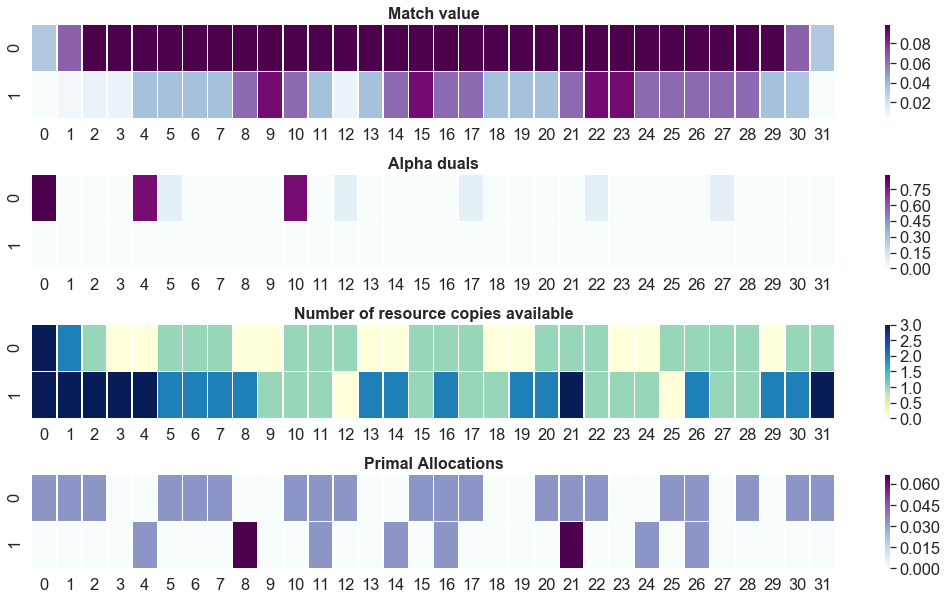

In [163]:
I=3
J=30
d=2
T=J+d
c = np.array([J,3,3])
k = np.array([1,5,5])

weights, allocs, alphas, resources_used, resources_available = simulate_average_resource_uses(I,J,T,c,k,d,arrival='Random',weights=[.99,.1,.9],n_runs=1)
plot_alloc_heatmap(weights, allocs, alphas, resources_available, resources_used)


### Same plot but with a fixed arrival order

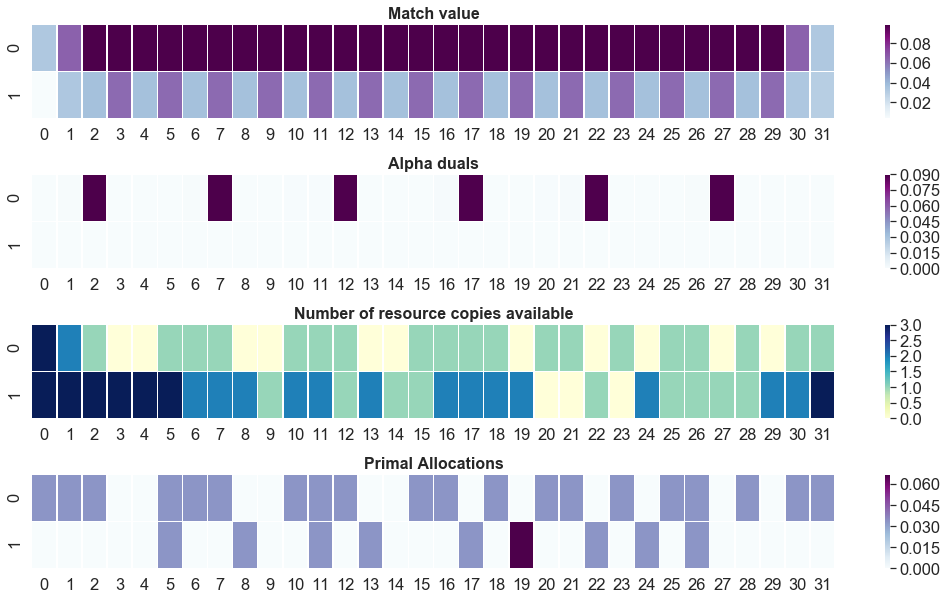

In [164]:
weights, allocs, alphas, resources_used, resources_available = simulate_average_resource_uses(I,J,T,c,k,d,arrival='Fixed',weights=[.99,.1,.9],n_runs=1)
plot_alloc_heatmap(weights, allocs, alphas, resources_available, resources_used)



### Generating the scenario and running 20 times, averaging across runs. 

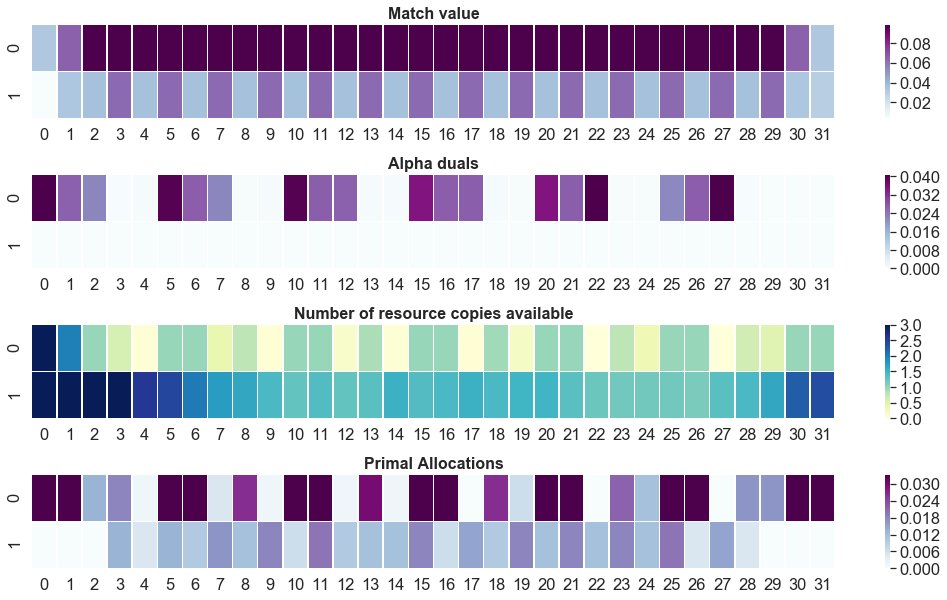

In [171]:
c = np.array([J,3,3])
k = np.array([1,5,5])

weights, allocs, alphas, resources_used, resources_available = simulate_average_resource_uses(I,J,T,c,k,d,arrival='Fixed',weights=[.99,.1,.9],n_runs=20)
plot_alloc_heatmap(weights, allocs, alphas, resources_available, resources_used)


## Finding alphas part 1: Finding mean vector from simulations

In [53]:
display_dict = {'Baseline': 'Randomly generated', 'Random':'Stocastic A&B', 'Fixed':'Fixed A&B','Batch':'Adversarial A&B'}
def mean_alpha_vector(I,J,T, N_SIMULATION, N_TEST, weights, k, c, arrivals):
    alpha_runs = np.zeros((N_SIMULATION, I*T))
    alloc_runs = np.zeros((N_SIMULATION, I,J,T))

    #Simulate several runs to get an average alpha vector for the scenario
    for i in range(N_SIMULATION):
        valid_matches, pairing_weights = create_tableau_exp1(I,J,T,arrivals, weights)

        objp, allocs = primal_solutions(valid_matches, pairing_weights, I, J, T)
        objd, alphas, betas = dual_solutions(valid_matches,pairing_weights, I, J, T)
        objo, online_allocations = online_matching(I,J,T,k,c,alphas,betas,allocs,valid_matches,pairing_weights)
        objg, greedy_allocs = greedy_matching(I,J,T,k,c,valid_matches,pairing_weights)

        alpha_runs[i,:] = alphas
        alloc_runs[i,:,:,:] = allocs

    mean_alphas = alpha_runs.mean(axis=0)
    mean_alloc = alloc_runs.mean(axis=0).mean(axis=1)
    
    return mean_alphas, mean_alloc


def simulate_alphas(I,J,T, N_SIMULATION, N_TEST, weights, k, c):
    
    objps = []
    objos = []
    objgs = []
    snrs = []
    arvls = []
    
    for arrivals in ['Baseline','Random','Fixed','Batch']:
        
        mean_alphas, mean_alloc = mean_alpha_vector(I,J,T, N_SIMULATION, N_TEST, weights, k, c, arrivals)
       
        #Use the average vector to make allocation decisons several times
        for i in range(N_TEST):
            valid_matches, pairing_weights = create_tableau_exp1(I,J,T,arrivals, weights)
            objp, allocs = primal_solutions(valid_matches, pairing_weights, I, J, T)
            objo, online_allocations = online_matching(I,J,T,k,c,mean_alphas,betas,allocs,valid_matches,pairing_weights)
            objg, greedy_allocs = greedy_matching(I,J,T,k,c,valid_matches,pairing_weights)

            objps.append(objp)
            objos.append(objo)
            objgs.append(objg)
            snrs.append(((J - allocs.sum()) / allocs.sum()))
            arvls.append(display_dict[arrivals])
            
            rundf = pd.DataFrame({'Offline Primal':objps, 'Online Avg Dual':objos, 'Online Greedy':objgs, 'snrs':snrs, 'arrivals':arvls})

    return rundf


## Plot the change in alpha variables over time

In [55]:
N_SIMULATION = 50
N_TEST = 30

d=2
J=30
I=3
T = J+d 

k = np.array([1,5,5])
c = np.array([J,3,3])

### Alphas and allocations in scenario 2

In [ ]:
mean_alphas, mean_alloc = mean_alpha_vector(I,J,T, N_SIMULATION, N_TEST, [.99,.05,.95], k, c, 'Fixed')
plt.figure(figsize=(7,5))
sns.heatmap(mean_alphas.reshape(I,T), cmap="BuPu", linewidths=.5)

plt.figure(figsize=(7,5))
sns.heatmap(mean_alloc.reshape(I,T), cmap="YlGnBu", linewidths=.5)

In [ ]:
mean_alphas, mean_alloc = mean_alpha_vector(I,J,T, N_SIMULATION, N_TEST, [.99,.05,.95], k, c, 'Batch')
plt.figure(figsize=(7,5))
sns.heatmap(mean_alphas.reshape(I,T), cmap="BuPu", linewidths=.5)

plt.figure(figsize=(7,5))
sns.heatmap(mean_alloc.reshape(I,T), cmap="YlGnBu", linewidths=.5)

In [ ]:
mean_alphas, mean_alloc = mean_alpha_vector(I,J,T, N_SIMULATION, N_TEST, [.99,.05,.95], k, c, 'Random')
plt.figure(figsize=(7,5))
sns.heatmap(mean_alphas.reshape(I,T), cmap="BuPu", linewidths=.5)

plt.figure(figsize=(7,5))
sns.heatmap(mean_alloc.reshape(I,T), cmap="YlGnBu", linewidths=.5)

In [ ]:
mean_alphas, mean_alloc = mean_alpha_vector(I,J,T, N_SIMULATION, N_TEST, [.99,.05,.95], k, c, 'Baseline')
plt.figure(figsize=(7,5))
sns.heatmap(mean_alphas.reshape(I,T), cmap="BuPu", linewidths=.5)

plt.figure(figsize=(7,5))
sns.heatmap(mean_alloc.reshape(I,T), cmap="YlGnBu", linewidths=.5)

# Alphas and allocations in scenario 1

In [ ]:
k = np.array([1,5,15])
c = np.array([J,10,5])

mean_alphas, mean_alloc = mean_alpha_vector(I,J,T, N_SIMULATION, N_TEST, [.05,.1,.9], k, c, 'Fixed')
plt.figure(figsize=(7,5))
sns.heatmap(mean_alphas.reshape(I,T), cmap="BuPu", linewidths=.5)

plt.figure(figsize=(7,5))
sns.heatmap(mean_alloc.reshape(I,T), cmap="YlGnBu", linewidths=.5)

In [ ]:
mean_alphas, mean_alloc = mean_alpha_vector(I,J,T, N_SIMULATION, N_TEST, [.05,.1,.9], k, c, 'Random')
plt.figure(figsize=(7,5))
sns.heatmap(mean_alphas.reshape(I,T), cmap="BuPu", linewidths=.5)

plt.figure(figsize=(7,5))
sns.heatmap(mean_alloc.reshape(I,T), cmap="YlGnBu", linewidths=.5)

In [ ]:
mean_alphas, mean_alloc = mean_alpha_vector(I,J,T, N_SIMULATION, N_TEST, [.05,.1,.9], k, c, 'Batch')
plt.figure(figsize=(7,5))
sns.heatmap(mean_alphas.reshape(I,T), cmap="BuPu", linewidths=.5)

plt.figure(figsize=(7,5))
sns.heatmap(mean_alloc.reshape(I,T), cmap="YlGnBu", linewidths=.5)

In [ ]:
mean_alphas, mean_alloc = mean_alpha_vector(I,J,T, N_SIMULATION, N_TEST, [.05,.1,.9], k, c, 'Baseline')
plt.figure(figsize=(7,5))
sns.heatmap(mean_alphas.reshape(I,T), cmap="BuPu", linewidths=.5)

plt.figure(figsize=(7,5))
sns.heatmap(mean_alloc.reshape(I,T), cmap="YlGnBu", linewidths=.5)

### Closely examining a small example

In [ ]:
N_SIMULATION = 50
N_TEST = 30



d=2
J=6
I=3
T = J+d 

simulate_alphas_df = simulate_alphas(I,J,T, N_SIMULATION, N_TEST, [.99,.05,.95], k, c)
alphacat_df = pd.melt(simulate_alphas_df, value_vars=['Offline Primal','Online Avg Dual','Online Greedy'], id_vars=['snrs','arrivals'],var_name='Algorithm', value_name='Utility')
g = sns.catplot(x="Algorithm", y="Utility", hue="Algorithm",col='arrivals', data=alphacat_df, kind="violin")
g.set_xticklabels(rotation=30)

## Alpha encoding based on one arrival model, testing on a different arrival model

In [ ]:
N_SIMULATION = 50
N_TEST = 30

d=2
J=30
I=3
T = J+d 

### Test in each of the arrival models, train only based on batch

In [ ]:
k = np.array([1,5,5])
c = np.array([J,3,3])

I = 3

simulate_alphas_df = simulate_alphas(I,J,T, N_SIMULATION, N_TEST, [.99,.05,.95], k, c)
alphacat_df = pd.melt(simulate_alphas_df, value_vars=['Offline Primal','Online Avg Dual','Online Greedy'], id_vars=['snrs','arrivals'],var_name='Algorithm', value_name='Utility')
g = sns.catplot(x="Algorithm", y="Utility", hue="Algorithm",col='arrivals', data=alphacat_df, kind="violin")
g.set_xticklabels(rotation=30)


### Test in each of the arrival models, train only based on random

In [ ]:
k = np.array([1,5,5])
c = np.array([J,3,3])

I = 3

simulate_alphas_df = simulate_alphas(I,J,T, N_SIMULATION, N_TEST, [.99,.05,.95], k, c)
alphacat_df = pd.melt(simulate_alphas_df, value_vars=['Offline Primal','Online Avg Dual','Online Greedy'], id_vars=['snrs','arrivals'],var_name='Algorithm', value_name='Utility')
g = sns.catplot(x="Algorithm", y="Utility", hue="Algorithm",col='arrivals', data=alphacat_df, kind="violin")
g.set_xticklabels(rotation=30)

### Train in each of the arrival models, test in batch with all of them

In [ ]:
simulate_alphas_df = simulate_alphas(I,J,T, N_SIMULATION, N_TEST, [.99,.05,.95], k, c)
alphacat_df = pd.melt(simulate_alphas_df, value_vars=['Offline Primal','Online Avg Dual','Online Greedy'], id_vars=['snrs','arrivals'],var_name='Algorithm', value_name='Utility')
g = sns.catplot(x="Algorithm", y="Utility", hue="Algorithm",col='arrivals', data=alphacat_df, kind="violin")
g.set_xticklabels(rotation=30)



### Train in each of the arrival models, test in random with all of them

In [ ]:
simulate_alphas_df = simulate_alphas(I,J,T, N_SIMULATION, N_TEST, [.99,.05,.95], k, c)
alphacat_df = pd.melt(simulate_alphas_df, value_vars=['Offline Primal','Online Avg Dual','Online Greedy'], id_vars=['snrs','arrivals'],var_name='Algorithm', value_name='Utility')
g = sns.catplot(x="Algorithm", y="Utility", hue="Algorithm",col='arrivals', data=alphacat_df, kind="violin")
g.set_xticklabels(rotation=30)


## Evaluating how the method works in different scenarios 

In [ ]:

k = np.array([1,5,5])
c = np.array([J,3,3])

simulate_alphas_df = simulate_alphas(I,J,T, N_SIMULATION, N_TEST, [.99,.05,.95], k, c)
alphacat_df = pd.melt(simulate_alphas_df, value_vars=['Offline Primal','Online Avg Dual','Online Greedy'], id_vars=['snrs','arrivals'],var_name='Algorithm', value_name='Utility')
g = sns.catplot(x="Algorithm", y="Utility", hue="Algorithm",col='arrivals', data=alphacat_df, kind="violin")
g.set_xticklabels(rotation=30)



In [ ]:
k = np.array([1,5,15])
c = np.array([J,10,5])

simulate_alphas_df = simulate_alphas(I,J,T, N_SIMULATION, N_TEST, [.05,.1,.9], k, c)
alphacat_df = pd.melt(simulate_alphas_df, value_vars=['Offline Primal','Online Avg Dual','Online Greedy'], id_vars=['snrs','arrivals'],var_name='Algorithm', value_name='Utility')
g = sns.catplot(x="Algorithm", y="Utility", hue="Algorithm",col='arrivals', data=alphacat_df, kind="violin")
g.set_xticklabels(rotation=30)



In [ ]:
k = np.array([1,T,T])
c = np.array([J,3,3])

simulate_alphas_df = simulate_alphas(I,J,T, N_SIMULATION, N_TEST, [.05,.1,.9], k, c)
alphacat_df = pd.melt(simulate_alphas_df, value_vars=['Offline Primal','Online Avg Dual','Online Greedy'], id_vars=['snrs','arrivals'],var_name='Algorithm', value_name='Utility')
g = sns.catplot(x="Algorithm", y="Utility", hue="Algorithm",col='arrivals', data=alphacat_df, kind="violin")
g.set_xticklabels(rotation=30)

In [ ]:
k = np.array([1,T,T])
c = np.array([J,1,1])

simulate_alphas_df = simulate_alphas(I,J,T, N_SIMULATION, N_TEST, [.05,.1,.9], k, c)
alphacat_df = pd.melt(simulate_alphas_df, value_vars=['Offline Primal','Online Avg Dual','Online Greedy'], id_vars=['snrs','arrivals'],var_name='Algorithm', value_name='Utility')
g = sns.catplot(x="Algorithm", y="Utility", hue="Algorithm",col='arrivals', data=alphacat_df, kind="violin")
g.set_xticklabels(rotation=30)


In [ ]:
k = np.array([1,13,16,13,19,21])
c = np.array([J,3,4,2,1,6])
d = 4
I=6

simulate_alphas_df = simulate_alphas(I,J,T, N_SIMULATION, N_TEST, [.05,.1,.9], k, c)
alphacat_df = pd.melt(simulate_alphas_df, value_vars=['Offline Primal','Online Avg Dual','Online Greedy'], id_vars=['snrs','arrivals'],var_name='Algorithm', value_name='Utility')
g = sns.catplot(x="Algorithm", y="Utility", hue="Algorithm",col='arrivals', data=alphacat_df, kind="violin")
g.set_xticklabels(rotation=30)

In [ ]:
k = np.array([1,13,16])
c = np.array([J,3,4])
d = 4
I=3
J=30

simulate_alphas_df = simulate_alphas(I,J,T, N_SIMULATION, N_TEST, [.05,.1,.9], k, c)
alphacat_df = pd.melt(simulate_alphas_df, value_vars=['Offline Primal','Online Avg Dual','Online Greedy'], id_vars=['snrs','arrivals'],var_name='Algorithm', value_name='Utility')
g = sns.catplot(x="Algorithm", y="Utility", hue="Algorithm",col='arrivals', data=alphacat_df, kind="violin")
g.set_xticklabels(rotation=30)